In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor


from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler,Normalizer,QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import VarianceThreshold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [37]:
import warnings
warnings.filterwarnings("ignore")

Import data

In [38]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Machine_learning_labs/bio.csv')
validation_df = pd.read_csv('/Users/nazarlenisin/Desktop/Machine_learning_labs/bio_predict.csv')
df.head(2)

,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],logBCF
0,0,0.0,1.49,0.14,1.35,0.72,0,1,5,0.74
1,0,0.0,1.47,0.14,1.70,0.88,0,1,5,0.93


Preventing Data Leakage

In [39]:
train_df,test_df = train_test_split(df,test_size = 0.2,random_state = 42)

Generall outlook

In [40]:
train_df.shape

(543, 10)

In [41]:
train_df.columns

Index(['nHM', 'piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V', 'N-072', 'B02[C-N]',
       'F04[C-O]', 'logBCF'],
      dtype='object')

In [42]:
train_df = train_df.rename(columns = {'B02[C-N]': 'B02CN',
                                      'F04[C-O]': 'F04CO',
                                      'N-072': 'N072'})

test_df = test_df.rename(columns = {'B02[C-N]': 'B02CN',
                                      'F04[C-O]': 'F04CO',
                                      'N-072': 'N072'})

validation_df = validation_df.rename(columns = {'B02[C-N]': 'B02CN',
                                      'F04[C-O]': 'F04CO',
                                      'N-072': 'N072'})

In [43]:
train_df.dtypes

nHM         int64
piPC09    float64
PCD       float64
X2Av      float64
MLOGP     float64
ON1V      float64
N072        int64
B02CN       int64
F04CO       int64
logBCF    float64
dtype: object

In [44]:
train_df.isna().sum()

nHM       0
piPC09    0
PCD       0
X2Av      0
MLOGP     0
ON1V      0
N072      0
B02CN     0
F04CO     0
logBCF    0
dtype: int64

In [45]:
train_df = train_df[train_df.duplicated() == False]

Univariative outliers

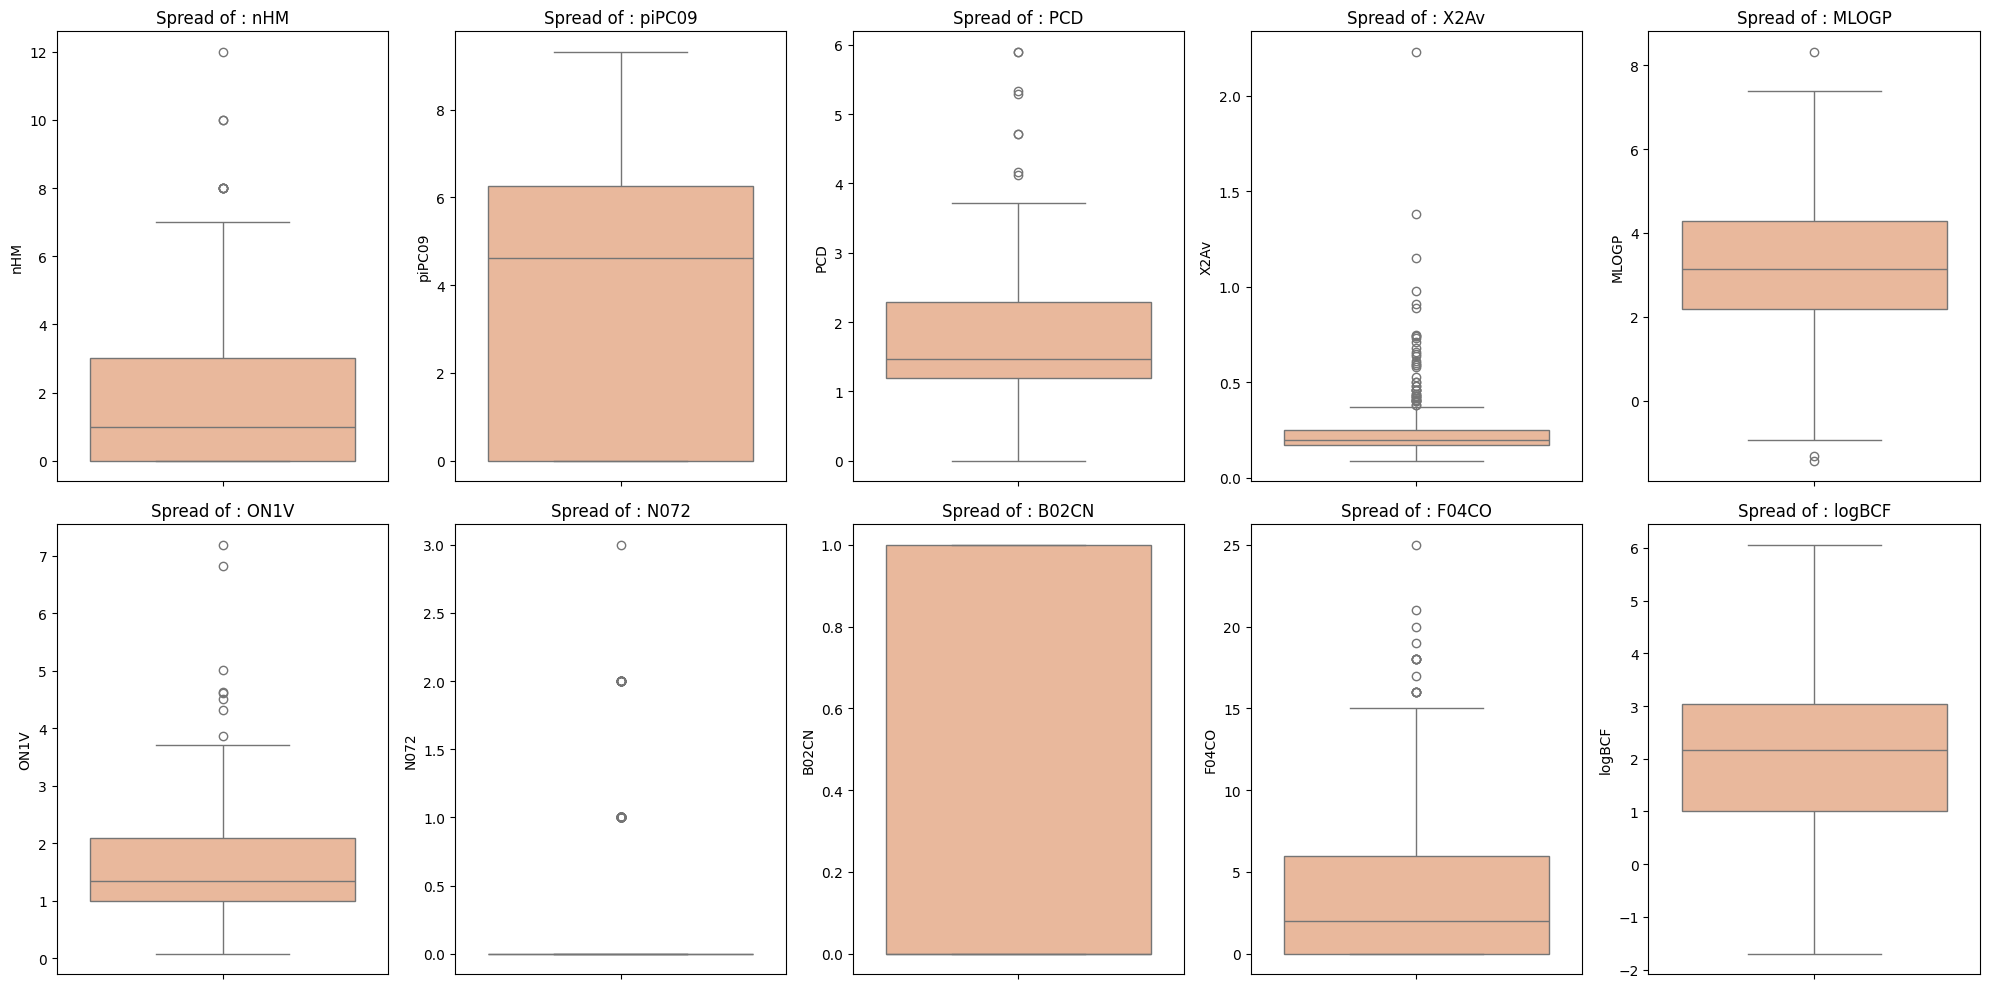

In [46]:
fig = plt.figure(figsize = (20,10))

for feature_idx,feature in enumerate(train_df.columns):
    plt.subplot(2,5,feature_idx + 1)
    sns.boxplot(data = train_df,y = feature,color = colors[-1])
    plt.title(f'Spread of : {feature}')
    
plt.tight_layout()
plt.show()

In [47]:
def winsorization(feature):
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_treshold = train_df[feature].quantile(0.95)#Q3 + 1.5 * Q3
    lower_treshold = train_df[feature].quantile(0.05) #Q1 - 1.5 * Q1
    
    if feature != 'logBCF':
        train_df[feature] = train_df[feature].apply(lambda x: float(np.nan) if x < lower_treshold else x)
        train_df[feature] = train_df[feature].apply(lambda x: float(np.nan) if x > upper_treshold else x)
    else:
        train_df[feature] = train_df[feature].drop(train_df.query('logBCF < -0.50125 or logBCF > 7.59375').index.to_list(),axis = 0)

In [48]:
for feature in train_df.columns:
    winsorization(feature)

Bivatiative outliers

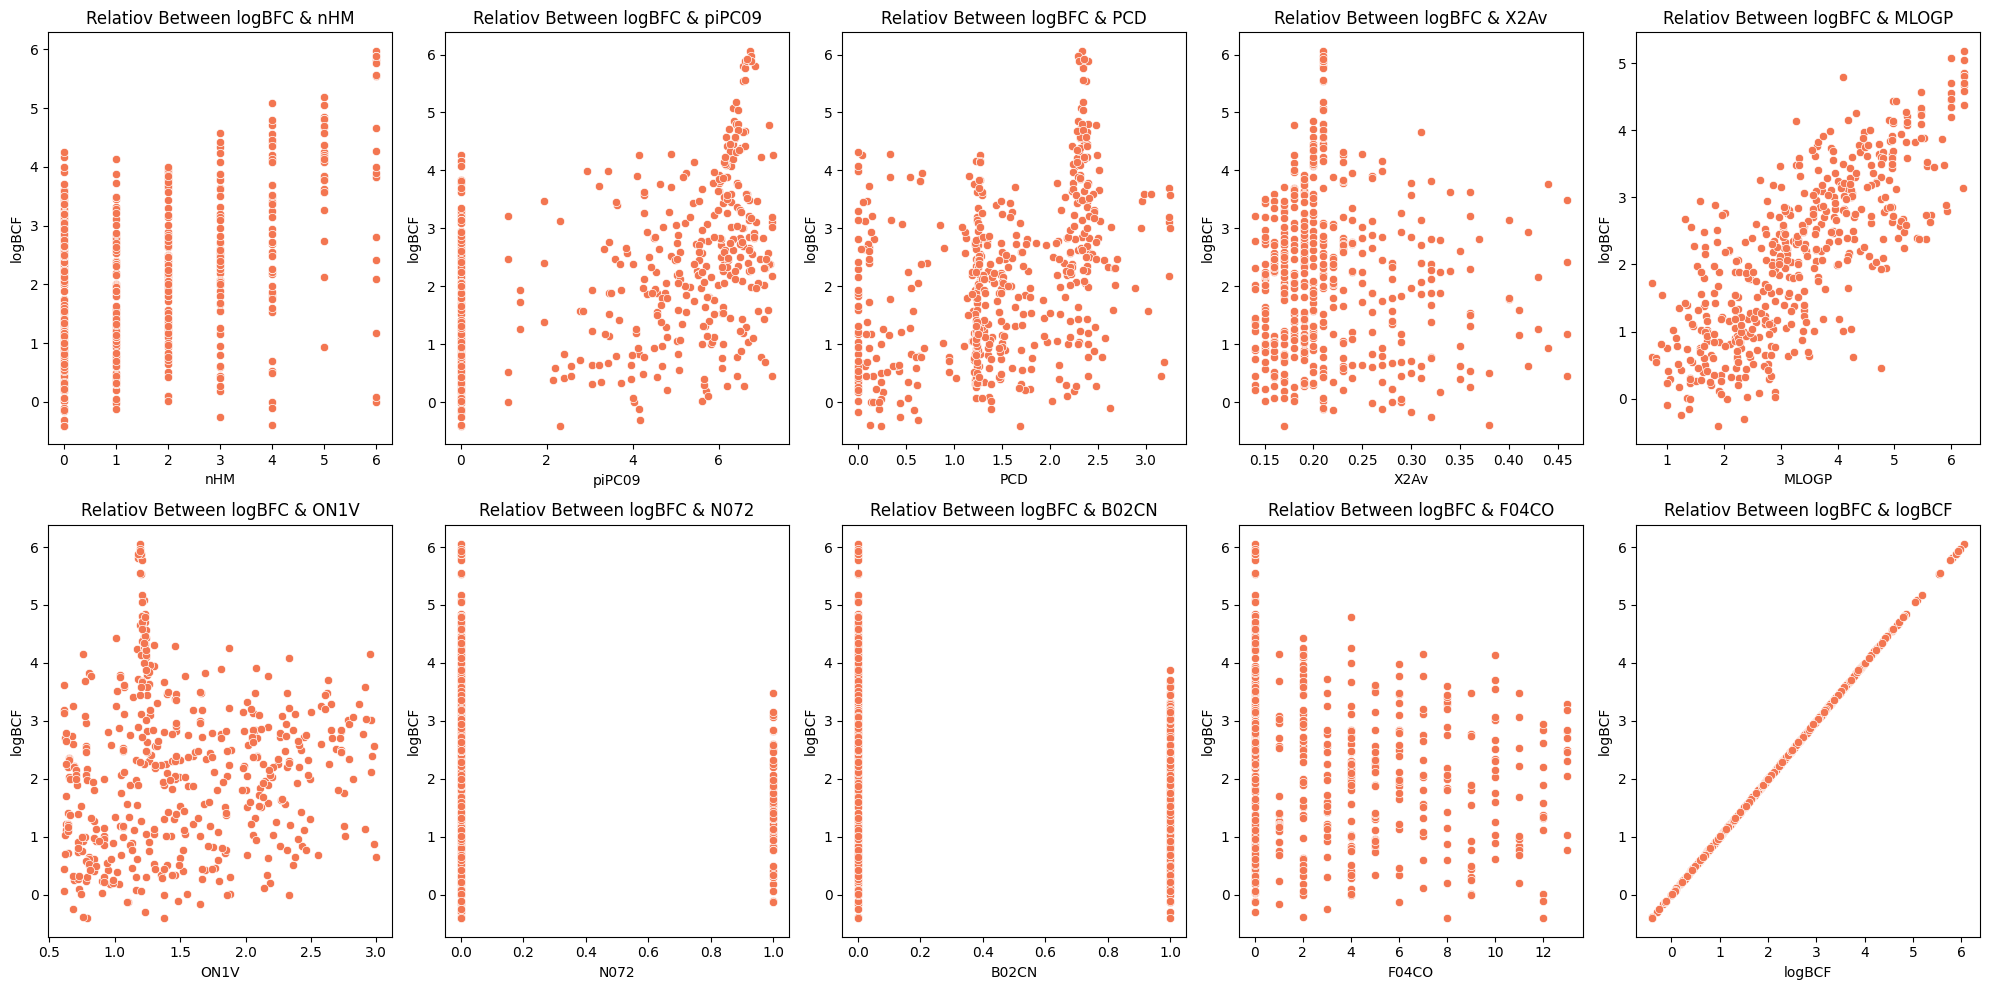

In [49]:
fig = plt.figure(figsize = (20,10))

for feature_idx,feature in enumerate(train_df.columns):
    plt.subplot(2,5,feature_idx + 1)
    sns.scatterplot(data = train_df,x = feature,y = 'logBCF',color = colors[-2])
    plt.title(f'Relatiov Between logBFC & {feature}')
    
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


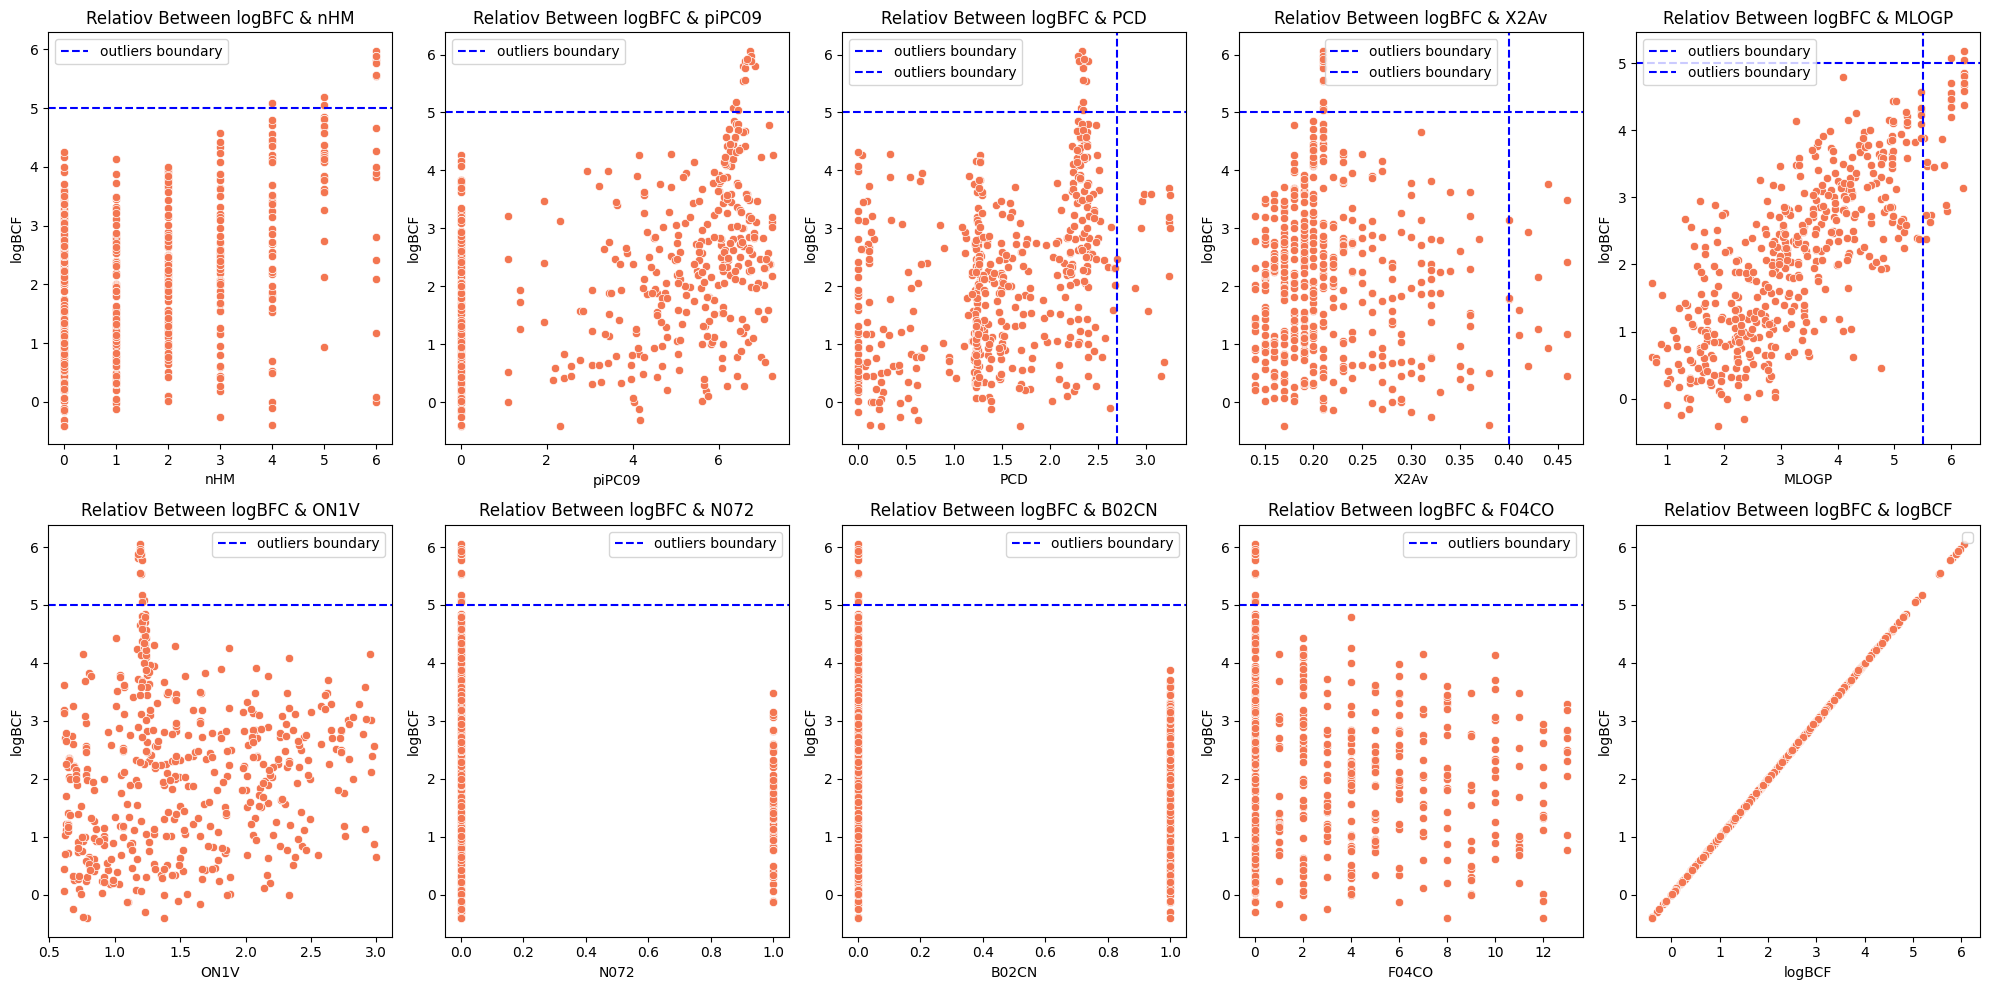

In [56]:

fig = plt.figure(figsize = (20,10))
outliers_x_treshold = [None,None,2.7,0.4,5.5,None,None,None,None,None]
outliers_y_treshold = [5,5,5,5,5,5,5,5,5,None]

for feature_idx,feature in enumerate(train_df.columns):
    plt.subplot(2,5,feature_idx + 1)
    sns.scatterplot(data = train_df,x = feature,y = 'logBCF',color = colors[-2])
    if outliers_x_treshold[feature_idx] != None:
        plt.axvline(outliers_x_treshold[feature_idx],linestyle='dashed',color = 'blue',label = 'outliers boundary')
    
    if outliers_y_treshold[feature_idx] != None:
        plt.axhline(outliers_y_treshold[feature_idx],linestyle='dashed',color = 'blue',label = 'outliers boundary')
    plt.title(f'Relatiov Between logBFC & {feature}')
    plt.legend()
    
plt.tight_layout()
plt.show()

In [15]:
train_df = train_df.drop(train_df.query('nHM > 5.5 and logBCF > 5.5').index.to_list(),axis = 0)
train_df['PCD'] = train_df['PCD'].apply(lambda x: 4 if x > 4 else x)
train_df['X2Av'] = train_df['X2Av'].apply(lambda x: 0.57 if x > 0.57 else x)
train_df['X2Av'] = train_df['X2Av'].apply(lambda x: 0.57 if x > 0.57 else x)
train_df = train_df.drop([139,317,339,265,205,339,87,458],axis = 0)
train_df['ON1V'] = train_df['ON1V'].apply(lambda x: 4 if x > 4 else x)

Feature Scaling

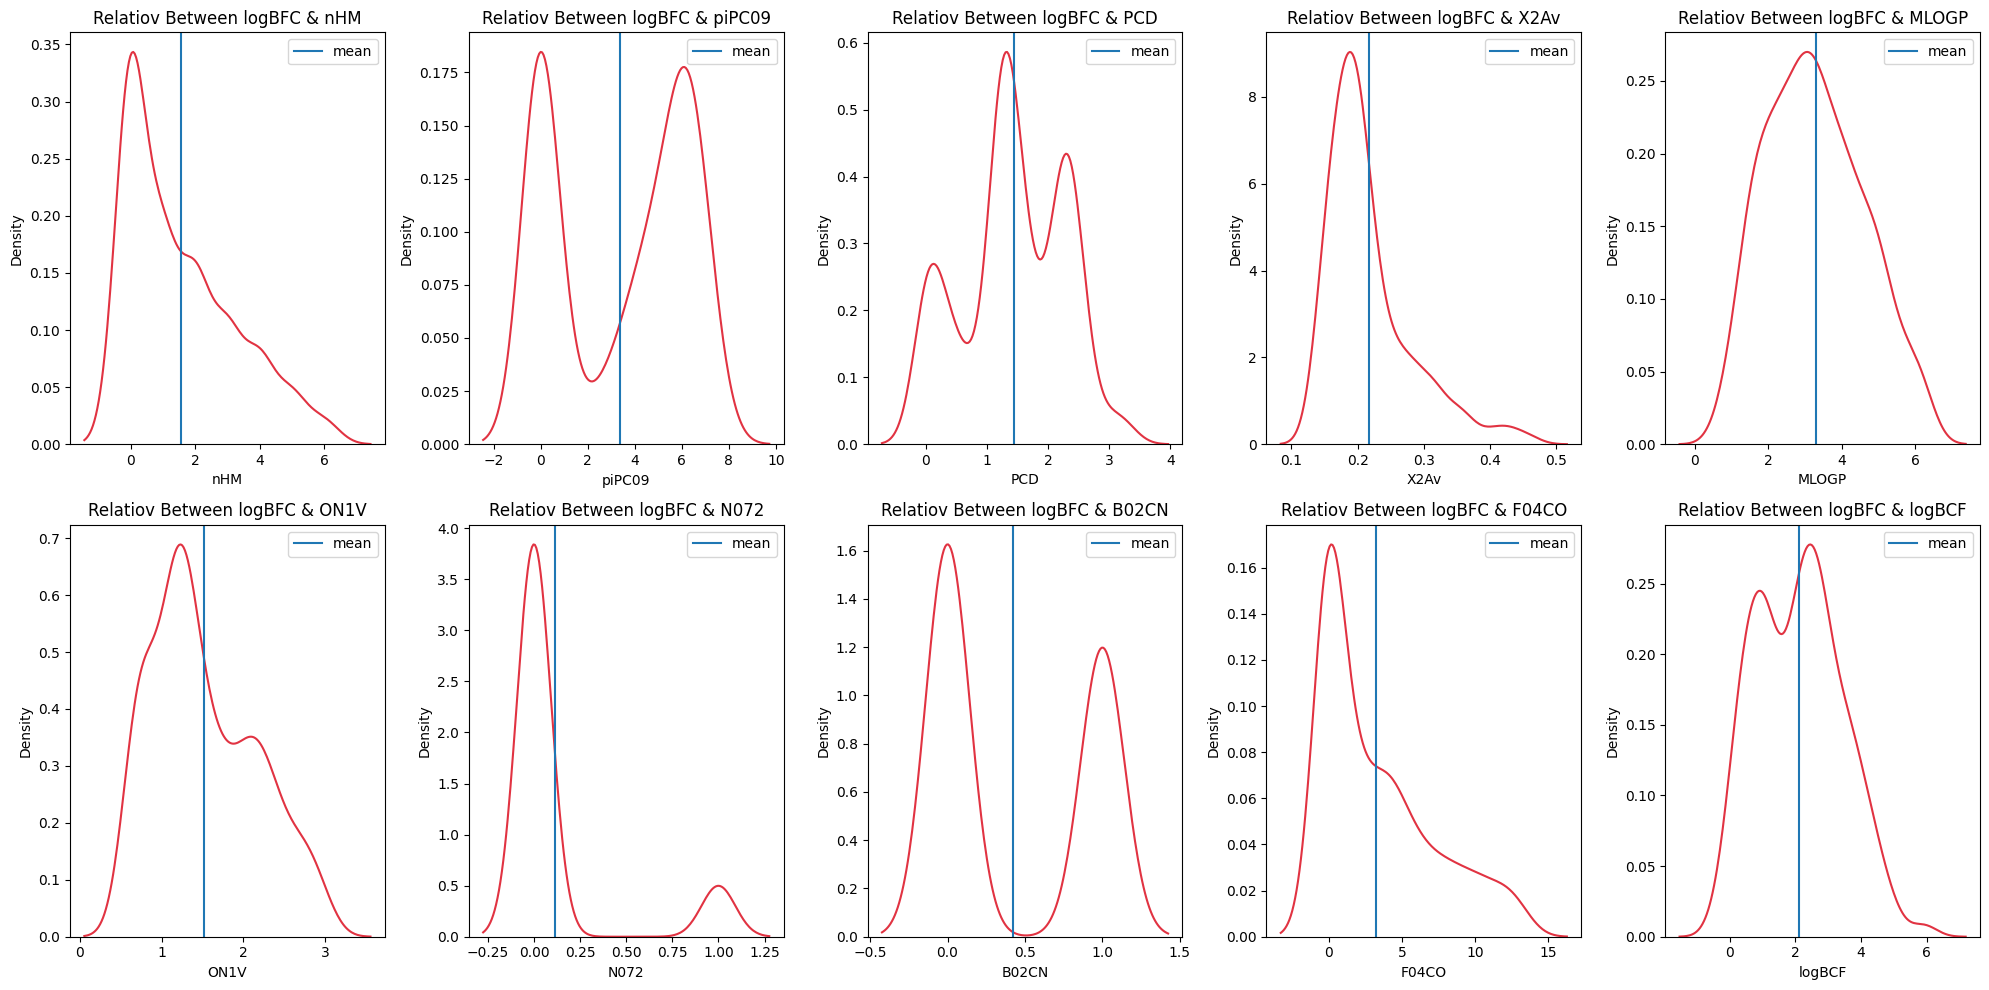

In [16]:
fig = plt.figure(figsize = (20,10))

for feature_idx,feature in enumerate(train_df.columns):
    plt.subplot(2,5,feature_idx + 1)
    sns.kdeplot(data = train_df,x = feature,color = colors[-3])
    plt.axvline(train_df[feature].mean(),label = 'mean')
    plt.title(f'Relatiov Between logBFC & {feature}')
    plt.legend()
    
plt.tight_layout()
plt.show()

In [17]:
numerical_transformer = Pipeline(steps = [
    ('normalize_distribution',QuantileTransformer()),
    ('scale_featuers',MinMaxScaler()),
    ('imputing_missing_values',SimpleImputer(strategy = 'mean'))
]).set_output(transform = 'pandas')


numerical_transformer

Pipeline(steps=[('normalize_distribution', QuantileTransformer()),
                ('scale_featuers', MinMaxScaler()),
                ('imputing_missing_values', SimpleImputer())])

In [18]:
features_to_scale = [column for column in train_df.columns if column != 'logBCF']

train_df[features_to_scale] = numerical_transformer.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = numerical_transformer.transform(test_df[features_to_scale])
validation_df[features_to_scale] = numerical_transformer.transform(validation_df[features_to_scale])

In [19]:
train_df = train_df.dropna()

Feature Selection

In [20]:
variance_treshold = VarianceThreshold(threshold = 0).set_output(transform = 'pandas')

train_df = pd.concat([variance_treshold.fit_transform(train_df[features_to_scale]),train_df['logBCF']],axis = 1)
test_df = pd.concat([variance_treshold.transform(test_df[features_to_scale]),test_df['logBCF']],axis = 1)
validation_df = variance_treshold.transform(validation_df[features_to_scale])

<Axes: >

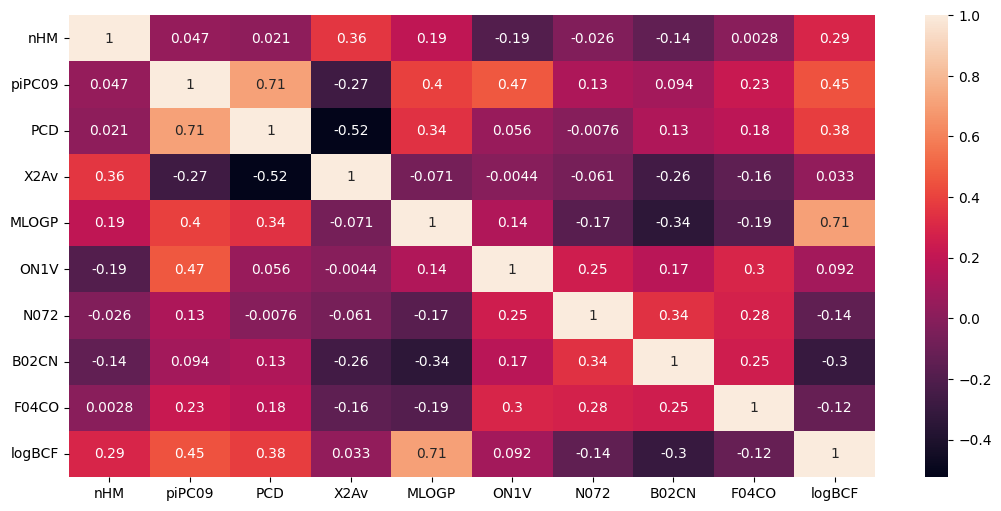

In [21]:
plt.figure(figsize = (13,6))
sns.heatmap(train_df.corr(),annot = True)

In [22]:
train_df = train_df.drop('PCD',axis = 1)
test_df = test_df.drop('PCD',axis = 1)
validation_df = validation_df.drop('PCD',axis = 1)

In [23]:
features = [column for column in train_df.columns if column != 'logBCF']

X_train = train_df[features]
y_train = train_df['logBCF']

X_test = test_df[features]
y_test = test_df['logBCF']

Model Building

In [24]:
class Voting_Model:
  def __init__(self,models,parameters):
    self.models = models
    self.parameters = parameters

  def fit(self,X,y,show_metric = False):
    from sklearn.ensemble import VotingRegressor
    from sklearn.metrics import r2_score

    models = []

    for model_idx,model in enumerate(self.models):
      if self.parameters[model_idx] != None:
        grid_search = GridSearchCV(model,self.parameters[model_idx],cv = 5)
        optimal_model = grid_search.fit(X,y).best_estimator_
        models.append(optimal_model)

      else:
        models.append(model)


    optimal_models = [(str(model),model) for model in models]
    voting_model = VotingRegressor(optimal_models)
    voting_model.fit(X,y)

    train_prediction = voting_model.predict(X)
    train_metric = r2_score(y,train_prediction)
    self.train_metric = train_metric

    if show_metric ==  True:
      print(f'R2 score on Train Data: {train_metric}')

    self.model = voting_model


  def eval(self,X,y):
    from sklearn.metrics import r2_score

    voting_model = self.model

    test_prediction = voting_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 score on Test Data: {test_loss}')


  def predict(self,X):
    voting_model = self.model
    prediction = voting_model.predict(X)

    return prediction

In [25]:
LinearRegression_params = None
SVR_params = {'kernel': ['linear','poly','rbf','sigmoid'],'C':[0.001,0.01,0.01,1,10]}
KNeighborsRegressor_params = {'n_neighbors': [3,5,7,10],'weights': ['uniform','distance']}
DecisionTreeRegressor_params = {'max_depth': [5,10,15],'min_samples_leaf': [3,5,10]}

models = [LinearRegression(),SVR(),KNeighborsRegressor(),DecisionTreeRegressor()]
parameters = [LinearRegression_params,SVR_params,KNeighborsRegressor_params,DecisionTreeRegressor_params]

voting_model = Voting_Model(models,parameters)
voting_model.fit(X_train,y_train,show_metric = True)
voting_model.eval(X_test,y_test)

R2 score on Train Data: 0.8489691268736186
R2 score on Test Data: 0.7640882692806643


In [26]:
class Bagging_Model:
  def __init__(self,model,parameters_estimator,parameters_model):
    self.model = model
    self.parameters_estimator = parameters_estimator
    self.parameters_model = parameters_model

  def fit(self,X,y,show_metric = False):
    from sklearn.metrics import r2_score
    from sklearn.ensemble import BaggingRegressor

    grid_search = GridSearchCV(self.model,self.parameters_estimator,cv = 5)
    model = grid_search.fit(X,y).best_estimator_

    bagging_model = BaggingRegressor(model)

    grid_search_bagging_model = GridSearchCV(bagging_model,self.parameters_model,cv = 5)
    optimal_bagging_model = grid_search_bagging_model.fit(X,y).best_estimator_

    if show_metric == True:
      train_prediction = optimal_bagging_model.predict(X)
      train_loss = r2_score(y,train_prediction)
      print(f'R2 score on Train Data: {train_loss}')

    self.bagging_model = optimal_bagging_model

  def eval(self,X,y):
    from sklearn.metrics import r2_score

    bagging_model = self.bagging_model
    test_prediction = bagging_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 score on Test Data: {test_loss}')

  def predict(self,X):
    bagging_model = self.bagging_model
    prediction = bagging_model.predict(X)

    return prediction

In [27]:
bagging_model_params = {'n_estimators': [5,10,15]}

bagging_model = Bagging_Model(DecisionTreeRegressor(),DecisionTreeRegressor_params,bagging_model_params)


bagging_model.fit(X_train,y_train,show_metric = True)
bagging_model.eval(X_test,y_test)

R2 score on Train Data: 0.7448262250029442
R2 score on Test Data: 0.7213037447089636


In [28]:
class Stacking_Model:
  def __init__(self,models,final_model,parameters_estimator):
    self.models = models
    self.final_model = final_model
    self.parameters_estimator = parameters_estimator

  def fit(self,X,y,show_metric = False):
    from sklearn.ensemble import StackingRegressor
    from sklearn.metrics import r2_score

    models = []

    for model_idx,model in enumerate(self.models):
      if self.parameters_estimator[model_idx] != None:
        grid_search = GridSearchCV(model,self.parameters_estimator[model_idx],cv = 5)
        optimal_model = grid_search.fit(X,y).best_estimator_
        models.append(optimal_model)

      else:
        models.append(model)


    optimal_models = [(str(model),model) for model in models]
    stacking_model = StackingRegressor(optimal_models,self.final_model)
    stacking_model.fit(X,y)
    self.stacking_model = stacking_model

    if show_metric == True:
      train_prediction = stacking_model.predict(X)
      train_loss = r2_score(y,train_prediction)
      print(f'R2 score on Train Data: {train_loss}')

  def eval(self,X,y):
    from sklearn.metrics import r2_score
    stacking_model = self.stacking_model
    test_prediction = stacking_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 score on Test Data: {test_loss}')

  def predict(self,X):
    stacking_model = self.stacking_model
    prediction = stacking_model.predict(X)

    return prediction

In [29]:
final_model = RidgeCV()
stacking_model = Stacking_Model(models,final_model,parameters)

stacking_model.fit(X_train,y_train,show_metric = True)
stacking_model.eval(X_test,y_test)
#stacking_model.predict(X_train)

R2 score on Train Data: 0.9532038571694126
R2 score on Test Data: 0.7581852215999247


In [30]:
class Ada_Boost_Model:
  def __init__(self,model,parameters_estimator,parameters_boost_model):
    self.model = model
    self.parameters_estimator = parameters_estimator
    self.parameters_boost_model = parameters_boost_model

  def fit(self,X,y,show_metric = False):
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.metrics import r2_score

    grid_search = GridSearchCV(self.model,self.parameters_estimator,cv = 5)
    model = grid_search.fit(X,y).best_estimator_

    ada_boost_model = AdaBoostRegressor(model)

    grid_search_ada = GridSearchCV(ada_boost_model,self.parameters_boost_model,cv = 5)
    optimal_ada_boost_model = grid_search_ada.fit(X,y).best_estimator_
    self.ada_boost_model = optimal_ada_boost_model

    if show_metric == True:
      train_prediction = optimal_ada_boost_model.predict(X)
      train_loss = r2_score(y,train_prediction)
      print(f'R2 score on Train Data: {train_loss}')

  def eval(self,X,y):
    from sklearn.metrics import r2_score
    ada_boost_model = self.ada_boost_model
    test_prediction = ada_boost_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 score on Test Data: {test_loss}')

  def predict(self,X):
    ada_boost_model = self.ada_boost_model
    prediction = ada_boost_model.predict(X)

    return prediction

In [31]:
ada_boost_base_estimator = DecisionTreeRegressor()
ada_boost_base_estimator_parameters = parameters[-1]
ada_boost_parameters = {'n_estimators': [5,10,15],'learning_rate': [0.0001,0.001,0.01,0.1,1],'loss': ['linear','square','exponential']}


ada_boost_model = Ada_Boost_Model(ada_boost_base_estimator,ada_boost_base_estimator_parameters,ada_boost_parameters)
ada_boost_model.fit(X_train,y_train,show_metric = True)
ada_boost_model.eval(X_test,y_test)

R2 score on Train Data: 0.8708323369064219
R2 score on Test Data: 0.7616964909177466


In [32]:
class Gradient_Boost_Model:
  def __init__(self,parameters_boost_model):
    self.parameters_boost_model = parameters_boost_model

  def fit(self,X,y,show_metric = False):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import r2_score

    gradient_boosting_model = GradientBoostingRegressor()

    grid_search_gradient_boosting = GridSearchCV(gradient_boosting_model,self.parameters_boost_model,cv = 5)
    optimal_gradient_boosting_model = grid_search_gradient_boosting.fit(X,y).best_estimator_
    self.gradient_boost_model = optimal_gradient_boosting_model

    if show_metric == True:
      train_prediction = optimal_gradient_boosting_model.predict(X)
      train_loss = r2_score(y,train_prediction)
      print(f'R2 score on Train Data: {train_loss}')

  def eval(self,X,y):
    from sklearn.metrics import r2_score

    gradient_boost_model = self.gradient_boost_model
    test_prediction = gradient_boost_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 score on Test Data: {test_loss}')

  def predict(self,X):
    gradient_boost_model = self.gradient_boost_model
    prediction = gradient_boost_model.predict(X)

    return prediction

In [33]:
gradient_boost_model_parameters = {'loss':['squared_error','absolute_error','huber'],'n_estimators':[5,10,15]}

gradient_boost_model = Gradient_Boost_Model(gradient_boost_model_parameters)

gradient_boost_model.fit(X_train,y_train,show_metric = True)
gradient_boost_model.eval(X_test,y_test)

R2 score on Train Data: 0.6687355358734162
R2 score on Test Data: 0.6951927072825002


In [34]:
class XGBoost_Model:
  def __init__(self,model_parameters):
    self.model_parameters = model_parameters

  def fit(self,X,y,show_metric = False):
    from sklearn.metrics import r2_score

    model = XGBRegressor()

    grid_search = GridSearchCV(model,self.model_parameters,cv = 5)
    xgb_model = grid_search.fit(X,y).best_estimator_
    self.xgb_model = xgb_model

    if show_metric == True:
      train_prediction = xgb_model.predict(X)
      train_loss = r2_score(y,train_prediction)
      print(f'R2 Score on Train Data: {train_loss}')

  def eval(self,X,y):
    from sklearn.metrics import r2_score
    xgb_model = self.xgb_model
    test_prediction = xgb_model.predict(X)
    test_loss = r2_score(y,test_prediction)
    self.test_loss = test_loss
    print(f'R2 Score on Test Data: {test_loss}')


  def predict(self,X):
    xgb_model = self.xgb_model
    prediction = xgb_model.predict(X)

    return prediction

In [35]:
xgboost_model_parameters = {
    'learning_rate': [0.05,0.1,0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0,0.1],
    'subsample' : [0.8,0.9,1.0],
    'colsample_bytree': [0.8,0.9,1.0]
}
xgboost_model = XGBoost_Model(xgboost_model_parameters)
xgboost_model.fit(X_train.values,y_train.values,show_metric = True)
xgboost_model.eval(X_test,y_test)
#xgboost_model.predict(X_test)

KeyboardInterrupt: 

Optimal model selection

In [ ]:
def Optimal_Model(models,show_metrics = False):
  models_loss = np.array([model.test_loss for model in models])
  optimal_model_idx = np.argmax(models_loss)
  optimal_model = models[optimal_model_idx]

  if show_metrics == True:
    for model_idx,model in enumerate(models):
      print(f'Model: {model}')
      print(f'Model Loss: {models_loss[model_idx]}\n')

    print(f'Optimal Model: {optimal_model}')

  return optimal_model

In [ ]:
optimal_model_candidates = [voting_model,bagging_model,stacking_model,ada_boost_model,gradient_boost_model,xgboost_model]

optimal_model = Optimal_Model(optimal_model_candidates,show_metrics = True)

Model: <__main__.Voting_Model object at 0x13a84d7d0>
Model Loss: 0.7640882692806643

Model: <__main__.Bagging_Model object at 0x13cdb8290>
Model Loss: 0.7189518991496443

Model: <__main__.Stacking_Model object at 0x13cfe5610>
Model Loss: 0.758185221599922

Model: <__main__.Ada_Boost_Model object at 0x13cefedd0>
Model Loss: 0.7492636336666318

Model: <__main__.Gradient_Boost_Model object at 0x13cf96e10>
Model Loss: 0.6951927072825002

Model: <__main__.XGBoost_Model object at 0x1398db690>
Model Loss: 0.7433618685546171

Optimal Model: <__main__.Voting_Model object at 0x13a84d7d0>


In [ ]:
optimal_model

Prediction for submission

In [ ]:
prediction = optimal_model.predict(validation_df)

In [ ]:
best_reg_model_predictions = prediction.reshape(-1)

In [ ]:
pd.Series(best_reg_model_predictions).to_csv('predictions_reg.csv')